Test

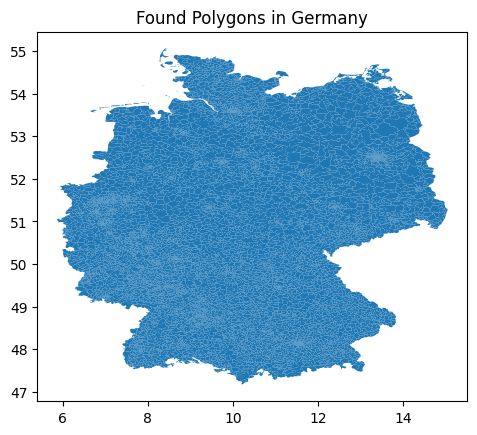

GeoJSON data saved to temp_geojson_data.geojson


In [2]:
# Script 1: Generate GeoJSON and Save to Temporary File

import osmnx as ox
import geopandas as gpd
from shapely.geometry import MultiPolygon, Polygon
import json
import os
import matplotlib.pyplot as plt

# Function to handle MultiPolygon geometries
def handle_multipolygon(multipolygon):
    if isinstance(multipolygon, MultiPolygon):
        polygons = [Polygon(list(poly.exterior.coords)) for poly in multipolygon.geoms]
        return polygons
    elif isinstance(multipolygon, Polygon):
        return [multipolygon]
    else:
        print(f"Unhandled geometry type: {type(multipolygon)}")
        return []


# Set the default CRS to EPSG:25832
ox.settings.default_crs = "epsg:25832"

# Your existing code to fetch place polygons
place_name = "Germany"
tags = {"boundary": "postal_code"}
place_polygons = ox.features_from_place(place_name, tags)

# Check if the word "POLYGON" is present in the geometry column (case-sensitive)
polygon_mask = place_polygons['geometry'].apply(lambda geom: 'POLYGON' in str(geom))

# Use isin to filter the GeoDataFrame
filtered_place_polygons = place_polygons[polygon_mask]

# Plot all found polygons
filtered_place_polygons.plot()
plt.title("Found Polygons in Germany")
plt.show()

# Create GeoDataFrame and drop rows with missing postal_code or geometry
gdf = gpd.GeoDataFrame(filtered_place_polygons).dropna(subset=['postal_code', 'geometry'])

# Create a dictionary to store postal codes and corresponding geometries
postal_code_polygon_dict = {}

# Iterate through GeoDataFrame rows to create the dictionary
for _, feature in gdf.iterrows():
    postal_code = feature['postal_code']
    geometry = feature['geometry']

    geometries = handle_multipolygon(geometry)

    postal_code_polygon_dict[postal_code] = geometries

# Convert the dictionary to GeoJSON format
geojson_data = {"type": "FeatureCollection", "features": []}
for postal_code, geometries in postal_code_polygon_dict.items():
    for geometry in geometries:
        feature = {
            "type": "Feature",
            "geometry": {
                "type": "Polygon",
                "coordinates": [list(geometry.exterior.coords)]
            },
            "properties": {
                "postal_code": postal_code
            }
        }
        geojson_data["features"].append(feature)

# Save the GeoJSON data to a temporary file
temp_geojson_file = "temp_geojson_data.geojson"
with open(temp_geojson_file, 'w') as temp_file:
    json.dump(geojson_data, temp_file)

# Display path to the temporary GeoJSON file
print(f"GeoJSON data saved to {temp_geojson_file}")


In [3]:
# Script 2: Connect to MongoDB and Insert GeoJSON Data

from pymongo import MongoClient
import json
import os

# MongoDB Connector Class
class MongoDBConnector:
    def __init__(self, database_name, collection_name):
        self.client = MongoClient('localhost', 27017)
        self.db = self.client[database_name]
        self.collection = self.db[collection_name]

    def connect_to_local_mongodb(self):
        print("Connected to local MongoDB")
        return self.client, self.collection

    def insert_geojson_data(self, geojson_file_path, chunk_size=1000):
        with open(geojson_file_path, 'r') as file:
            geojson_data = json.load(file)

        features = geojson_data["features"]
        for i in range(0, len(features), chunk_size):
            chunk = features[i:i + chunk_size]
            self.collection.insert_many(chunk)
            print(f"Inserted {len(chunk)} features into local MongoDB collection '{self.collection.name}'.")

    def close_connection(self):
        self.client.close()
        print("Closed MongoDB connection.")

# Example usage of the class
if __name__ == "__main__":
    # User input for the database and collection names
    database_name = "ZIP_Poly_Ger_DB_d"
    collection_name = "ZIP_Poly_Ger_Collection_d"

    # Create an instance of MongoDBConnector
    mongo_connector = MongoDBConnector(database_name, collection_name)

    # Connect to MongoDB
    mongo_client, mongo_collection = mongo_connector.connect_to_local_mongodb()

    # Example GeoJSON file path (use the path to the temporary file generated by Script 1)
    geojson_file_path = 'temp_geojson_data.geojson'

    # Insert GeoJSON data into MongoDB
    mongo_connector.insert_geojson_data(geojson_file_path, chunk_size=1000)

    # Close MongoDB connection when done
    mongo_connector.close_connection()

    # Clean up: Remove the temporary GeoJSON file
    os.remove(geojson_file_path)


Connected to local MongoDB
Inserted 1000 features into local MongoDB collection 'ZIP_Poly_Ger_Collection_d'.
Inserted 1000 features into local MongoDB collection 'ZIP_Poly_Ger_Collection_d'.
Inserted 1000 features into local MongoDB collection 'ZIP_Poly_Ger_Collection_d'.
Inserted 1000 features into local MongoDB collection 'ZIP_Poly_Ger_Collection_d'.
Inserted 1000 features into local MongoDB collection 'ZIP_Poly_Ger_Collection_d'.
Inserted 1000 features into local MongoDB collection 'ZIP_Poly_Ger_Collection_d'.
Inserted 1000 features into local MongoDB collection 'ZIP_Poly_Ger_Collection_d'.
Inserted 1000 features into local MongoDB collection 'ZIP_Poly_Ger_Collection_d'.
Inserted 802 features into local MongoDB collection 'ZIP_Poly_Ger_Collection_d'.
Closed MongoDB connection.
